In [ ]:
import numpy as np
import matplotlib.pyplot as plt

eta = 0.1
T = 100
x, y = 1.0, 1.0  # starting point
xs, ys = [x], [y]

for _ in range(T):
    x, y = x - eta * y, y + eta * x  # GDA update
    xs.append(x); ys.append(y)

plt.plot(xs, ys, 'o-', markersize=3)
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.title("GDA on f(x,y)=xy")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal')
plt.show()


In [4]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 50
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [5]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np


# Generate RX positions

distances_km = [0.5]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(120, 80),(45, 90), (75,75),(80,88), (65, 85),(130,75)]
# angles = [(1, 90-(1e-3)), (60, 87), (120,84),(180,80), (240, 82),(300,80)]
angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]
# angles = [(45, 90-(1e-3)), (220, 87), (75,85)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


TX0(m): [0. 0. 0.]
TX1(m): [ 3.06161699e-14  4.99999999e+02 -1.96201537e-02]

Satellite Pos [m]:
 [[ 6.78773782e+00  6.78773782e+00  5.50000000e+05]
 [ 2.49598339e+04 -1.44105668e+04  5.49939990e+05]
 [ 4.64650302e+04  1.24502673e+04  5.49832825e+05]
 [ 6.64657608e+04  1.17197069e+04  5.49670918e+05]
 [ 7.00003929e+04  3.26417193e+04  5.49569013e+05]
 [ 7.41993110e+04 -6.22606145e+04  5.49322180e+05]]

From TX0:
  SAT0: az=45.00°, el=90.00°, dist=550000.00 m, λ count ≈ 18333333.34
  SAT1: az=120.00°, el=87.00°, dist=550694.70 m, λ count ≈ 18356489.92
  SAT2: az=75.00°, el=85.00°, dist=551933.10 m, λ count ≈ 18397769.90
  SAT3: az=80.00°, el=83.00°, dist=553798.85 m, λ count ≈ 18459961.68
  SAT4: az=65.00°, el=82.00°, dist=554969.94 m, λ count ≈ 18498998.08
  SAT5: az=130.00°, el=80.00°, dist=557796.36 m, λ count ≈ 18593212.01

From TX1:
  SAT0: az=179.21°, el=89.95°, dist=550000.24 m, λ count ≈ 18333341.36
  SAT1: az=120.85°, el=86.97°, dist=550708.03 m, λ count ≈ 18356934.27
  SAT2: a

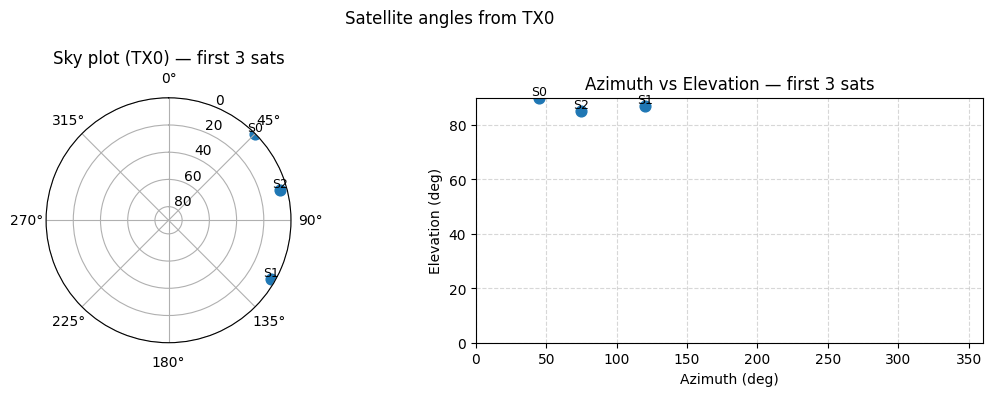

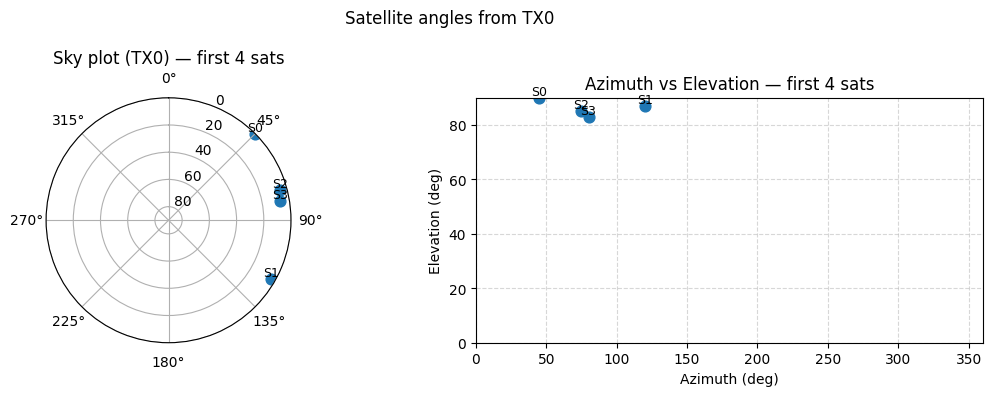

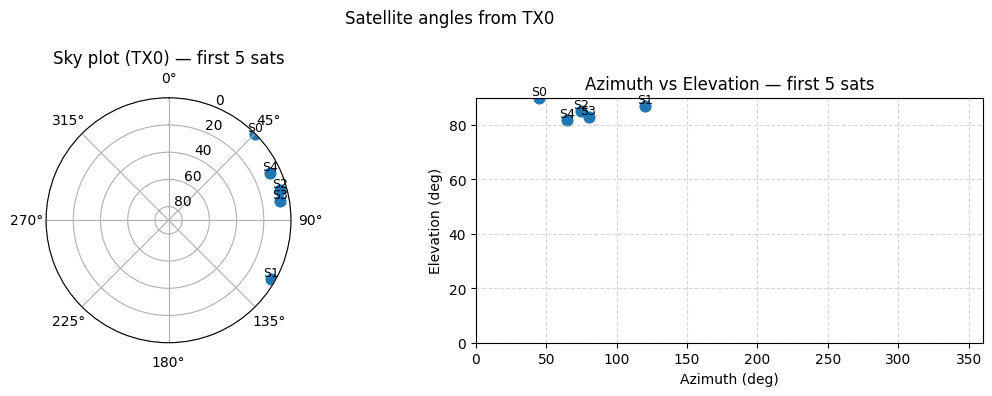

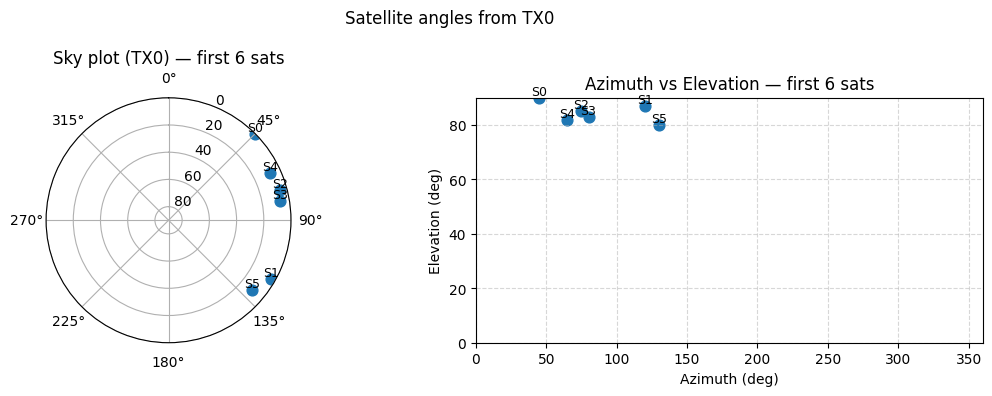

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Choose which ground TX viewpoint to use (0 = first one you printed)
tx_idx = 0  

def sats_az_el_for_k(k, tx_pos):
    az_list, el_list = [], []
    for j in range(k):
        az, el, dist, n_waves = compute_az_el_dist(sat_positions[j], tx_pos, frequency_hz)
        az_list.append(az)
        el_list.append(el)
    return np.array(az_list), np.array(el_list)

# Make four figures for k = 3,4,5,6
for k in [3, 4, 5, 6]:
    az, el = sats_az_el_for_k(k, gnd_positions[tx_idx])

    fig = plt.figure(figsize=(11, 4))

    # ---- (Left) Polar sky plot: radius = 90 - elevation (0 at zenith) ----
    ax1 = plt.subplot(1, 2, 1, projection='polar')
    theta = np.deg2rad(az)                 # azimuth in radians
    r = 90.0 - el                          # zenith angle
    sc = ax1.scatter(theta, r, s=60)
    # Annotate satellite indices
    for j in range(k):
        ax1.text(theta[j], r[j], f"S{j}", ha='center', va='bottom', fontsize=9)
    ax1.set_rlim(90, 0)                    # zenith at center
    ax1.set_theta_zero_location("N")       # 0° at North (up)
    ax1.set_theta_direction(-1)            # azimuth increasing clockwise
    ax1.set_title(f"Sky plot (TX{tx_idx}) — first {k} sats")

    # ---- (Right) Cartesian azimuth vs elevation ----
    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(az, el, s=60)
    for j in range(k):
        ax2.text(az[j], el[j], f"S{j}", ha='center', va='bottom', fontsize=9)
    ax2.set_xlim(0, 360)
    ax2.set_ylim(0, 90)
    ax2.set_xlabel("Azimuth (deg)")
    ax2.set_ylabel("Elevation (deg)")
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_title(f"Azimuth vs Elevation — first {k} sats")

    plt.suptitle(f"Satellite angles from TX{tx_idx}")
    plt.tight_layout()
    plt.show()


In [7]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np

def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = Scene()
    scene.frequency = frequency
    scene.synthetic_array = True

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at)
        rx_list.append(rx)

    tx.look_at(tx_look_at)  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all


jitc_llvm_init(): LLVM API initialization failed ..


In [8]:
import vsat_dish_3gpp
jam_rows =8
jam_cols = 8
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")




In [9]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t




In [ ]:
a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])
a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])
H0 = collapse_channel(a_tx)
H1 = collapse_channel(a_jam)



N0 = noise_power_watt
P0 = Tx_power_watt
P1 = jam_power_watt


In [15]:
from minmax_solvers import solve_game_mirror_prox, solve_game_bestresp_Q0_then_Q1, solve_game_proxBR, solve_game_extragradient, solve_game_pdhg

In [ ]:
n1 = H1.shape[1]
Q1_init = (P1/n1) * np.eye(n1, dtype=complex)
# 参数准备
Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
    H0, H1, N0, 
    P0=P0, P1=P1,
    max_outer=5000, tol=1e-6, inner_Q1_steps=4,
    geometry='entropy',      # 'euclidean' → Extragradient; 'entropy' → Mirror-Prox
    step_rule='adp',         # 'fixed' → 固定步长; 'adp-eta' → 自适应步长
    eta=0.5,                   # 仅在 step_rule='fixed' 时使用
    eta_init=0.3,              # 自适应时的初始步长
    eta_min=1e-2, eta_max=0.7, # 自适应时的步长范围
    beta=0.5, gamma=1.01,       # backtracking 收缩/扩张参数
    multi_stream=True,         # 用户水填充分配模式
    verbose=True,              # 打印每次迭代
    track_hist=True,            # 记录历史曲线
    Q1_init = Q1_init
)

# 查看收敛过程
import matplotlib.pyplot as plt
plt.plot(hist['J']); plt.title("Rate J"); plt.show()
plt.plot(hist['errQ1']); plt.title("errQ1"); plt.show()
plt.plot(hist['eta']); plt.title("eta evolution"); plt.show()

In [ ]:
Q0, Q1, hist = solve_game_proxBR(
    H0, H1, N0, P0, P1,
    rho=1e-2,
    outer_steps=1000, outer_tol=1e-6,
    inner_max=200, inner_tol=1e-6,
    eta0_inner=0.5,         # 内层初始步长
    beta=0.5, gamma=1.1,     # 回溯收缩/温和放大
    eta_min=1e-2, eta_max=1.0,
    eta_probe=0.1,           # residual 的“测温”步长
    min_outer=5,             # 防第一轮早停
    verbose=True, track_hist=True
)


import matplotlib.pyplot as plt
plt.plot(hist['J']);        plt.title("J");         plt.show()
plt.plot(hist['errQ1']);    plt.title("errQ1");     plt.show()
plt.plot(hist['residual']); plt.title("residual");  plt.show()
plt.plot(hist['trQ1']);     plt.title("tr(Q1)");    plt.show()

In [ ]:
n1 = H1.shape[1]
Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

Q0_mp, Q1_mp, hist_mp = solve_game_mirror_prox(
    H0, H1, N0, P0, P1,
    steps=10000,
    eta=0.25,                 # 可试 0.2~0.4
    step_rule='adp',          # 自适应更快；不稳再换 fixed
    beta=0.3, gamma=1.03,     # 温和放大/缩小
    eta_min=1e-3, eta_max=1.0,
    strong_reg=0.0,           # 不稳时再开 1e-3
    Q0_init=None, Q1_init=Q1_init,
    use_averaging=True,
    eta_probe=0.2,
    verbose=True, track_hist=True
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 你的 utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
# from your_module import compute_cir, collapse_channel   # 这里替换成你定义 compute_cir, collapse_channel 的文件/模块

# -------------------------
# 系统参数
# -------------------------
c = 3e8
fc = 10e9
wavelength = c/fc
bandwidth = 100e6
tx_power_dbm = 30
jam_power_dbm = 50
k = 1.38e-23
GT = 13
La = 5
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm - 30) / 10)
Jam_power_watt = 10 ** ((jam_power_dbm - 30) / 10)

# -------------------------
# 场景设置
# -------------------------
distances_km = [0.5]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]
for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

sat_orbit_m = 550e3
angles = [(1, 90-(1e-3)), (60, 87), (120,84), (180,80), (240, 82), (300,80)]
# angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]

# 阵列
tx_array = PlanarArray(num_rows=8, num_cols=8,
                       vertical_spacing=0.5, horizontal_spacing=0.5,
                       pattern="tr38901", polarization="V")
sat_array = PlanarArray(num_rows=1, num_cols=1,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="iso", polarization="V")

# -------------------------
# 实验配置
# -------------------------
methods = ["BestResp", "MirrorProx", "ProxBR"]
sat_counts = [3, 4, 5, 6]
results = {m: {} for m in methods}

# -------------------------
# 主循环
# -------------------------
for m in methods:
    for k in tqdm(sat_counts, desc=f"Method={m}"):
        # 截取前 k 个卫星
        sat_positions = []
        for az, el in angles[:k]:
            pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
            sat_positions.append(pos)
        sat_positions = np.array(sat_positions)

        # 构造信道
        a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array,
                                   sat_positions[0], gnd_positions[0])
        a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array,
                                     sat_positions[0], gnd_positions[0])
        H0 = collapse_channel(a_tx)
        H1 = collapse_channel(a_jam)

        N0 = noise_power_watt
        P0 = Tx_power_watt
        P1 = Jam_power_watt
        n1 = H1.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

        # 不同方法
        if m == "BestResp":
            Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
                        H0, H1, N0, 
                        P0=P0, P1=P1,
                        max_outer=3000, tol=1e-6, inner_Q1_steps=4,
                        geometry='entropy',      # 'euclidean' → Extragradient; 'entropy' → Mirror-Prox
                        step_rule='adp',         # 'fixed' → 固定步长; 'adp' → 自适应步长
                        eta=0.5,                   # 仅在 step_rule='fixed' 时使用
                        eta_init=0.3,              # 自适应时的初始步长
                        eta_min=1.5e-1, eta_max=0.9, # 自适应时的步长范围
                        beta=0.3, gamma=1.01,       # backtracking 收缩/扩张参数
                        multi_stream=True,         # 用户水填充分配模式
                        verbose=True,              # 打印每次迭代
                        track_hist=True,            # 记录历史曲线
                        Q1_init = Q1_init
                    )
            results[m][k] = hist

        elif m == "MirrorProx":
            Q0, Q1, hist = solve_game_mirror_prox(
                    H0, H1, N0, P0, P1,
                    steps=10000,
                    eta=0.25,                 # 可试 0.2~0.4
                    step_rule='adp',          # 自适应更快；不稳再换 fixed
                    beta=0.3, gamma=1.03,     # 温和放大/缩小
                    eta_min=1e-3, eta_max=1.0,
                    strong_reg=0.0,           # 不稳时再开 1e-3
                    Q0_init=None, Q1_init=Q1_init,
                    use_averaging=True,
                    eta_probe=0.2,
                    verbose=True, track_hist=True
                )
            results[m][k] = hist

        elif m == "ProxBR":
            Q0, Q1, hist = solve_game_proxBR(
                    H0, H1, N0, P0, P1,
                    rho=1e-2,
                    outer_steps=1000, outer_tol=1e-6,
                    inner_max=200, inner_tol=1e-6,
                    eta0_inner=0.5,         # 内层初始步长
                    beta=0.5, gamma=1.1,     # 回溯收缩/温和放大
                    eta_min=1e-2, eta_max=1.0,
                    eta_probe=0.1,           # residual 的“测温”步长
                    min_outer=5,             # 防第一轮早停
                    verbose=True, track_hist=True
                )
            results[m][k] = hist


Method=BestResp:   0%|          | 0/4 [00:00<?, ?it/s]

[outer 1] errQ0=nan, errQ1=3.464e-02, res=3.803e-02, J=4.3555, eta=0.312, trQ1=100.000000
[outer 2] errQ0=2.902e-02, errQ1=3.885e-02, res=4.079e-02, J=4.2282, eta=0.325, trQ1=100.000000
[outer 3] errQ0=2.592e-02, errQ1=4.329e-02, res=4.352e-02, J=4.1022, eta=0.338, trQ1=100.000000
[outer 4] errQ0=2.281e-02, errQ1=4.784e-02, res=4.615e-02, J=3.9773, eta=0.352, trQ1=100.000000
[outer 5] errQ0=1.982e-02, errQ1=5.235e-02, res=4.859e-02, J=3.8539, eta=0.366, trQ1=100.000000
[outer 6] errQ0=1.700e-02, errQ1=5.668e-02, res=5.079e-02, J=3.7324, eta=0.381, trQ1=100.000000
[outer 7] errQ0=1.440e-02, errQ1=6.068e-02, res=5.271e-02, J=3.6132, eta=0.396, trQ1=100.000000
[outer 8] errQ0=1.204e-02, errQ1=6.423e-02, res=5.432e-02, J=3.4969, eta=0.412, trQ1=100.000000
[outer 9] errQ0=9.928e-03, errQ1=6.723e-02, res=5.561e-02, J=3.3839, eta=0.429, trQ1=100.000000
[outer 10] errQ0=8.066e-03, errQ1=6.960e-02, res=5.659e-02, J=3.2746, eta=0.447, trQ1=100.000000
[outer 11] errQ0=6.443e-03, errQ1=7.130e-02, 

Method=MirrorProx:   0%|          | 0/4 [00:00<?, ?it/s]

[0001] J=0.6497, errQ0=1.23e-02, errQ1=6.11e-03, res=3.93e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0002] J=0.9514, errQ0=1.95e-02, errQ1=6.22e-03, res=3.49e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0003] J=1.3554, errQ0=3.20e-02, errQ1=6.30e-03, res=2.95e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0004] J=1.8542, errQ0=5.25e-02, errQ1=6.38e-03, res=2.42e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0005] J=2.3857, errQ0=7.88e-02, errQ1=6.50e-03, res=1.95e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0006] J=2.8581, errQ0=9.89e-02, errQ1=6.71e-03, res=1.56e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0007] J=3.2233, errQ0=1.03e-01, errQ1=6.96e-03, res=1.24e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0008] J=3.4869, errQ0=9.46e-02, errQ1=7.20e-03, res=9.67e-02, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0009] J=3.6722, errQ0=8.04e-02, errQ1=7.42e-03, res=9.64e-02, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0010] J=3.8012, errQ0=6.55e-02, errQ1=7.61e-03, res=9.89e-02, eta=0.25, trQ0=1.00

Method=ProxBR:   0%|          | 0/4 [00:00<?, ?it/s]

[001] J=3.0385, errQ0=7.17e-01, errQ1=8.63e+00, res=6.62e-01, trQ1=12.7215
[002] J=2.8865, errQ0=6.04e-01, errQ1=5.76e-01, res=5.41e-02, trQ1=17.6972
[003] J=2.6240, errQ0=5.56e-03, errQ1=2.90e-01, res=4.23e-02, trQ1=21.5073
[004] J=2.4469, errQ0=2.15e-03, errQ1=1.89e-01, res=3.55e-02, trQ1=24.6745
[005] J=2.3151, errQ0=1.00e-03, errQ1=1.39e-01, res=3.11e-02, trQ1=27.4243
[010] J=1.9372, errQ0=5.89e-05, errQ1=5.75e-02, res=2.04e-02, trQ1=37.8486
[020] J=1.6064, errQ0=1.39e-04, errQ1=2.56e-02, res=1.34e-02, trQ1=52.0227
[030] J=1.4339, errQ0=5.20e-05, errQ1=1.63e-02, res=1.05e-02, trQ1=62.4899
[040] J=1.3205, errQ0=3.33e-05, errQ1=1.18e-02, res=8.77e-03, trQ1=70.9943
[050] J=1.2375, errQ0=2.37e-05, errQ1=9.28e-03, res=7.64e-03, trQ1=78.2749
[060] J=1.1730, errQ0=1.80e-05, errQ1=7.61e-03, res=6.82e-03, trQ1=84.7033
[070] J=1.1205, errQ0=1.44e-05, errQ1=6.44e-03, res=6.20e-03, trQ1=90.4969
[080] J=1.0767, errQ0=1.17e-05, errQ1=5.58e-03, res=5.70e-03, trQ1=95.7953
[090] J=1.0414, errQ0=1.2

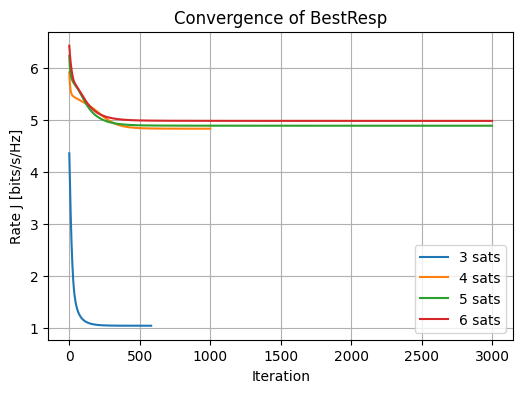

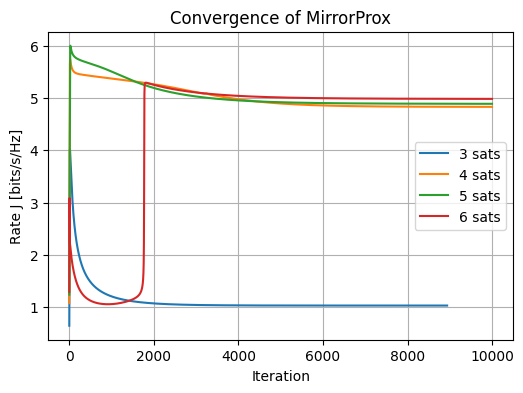

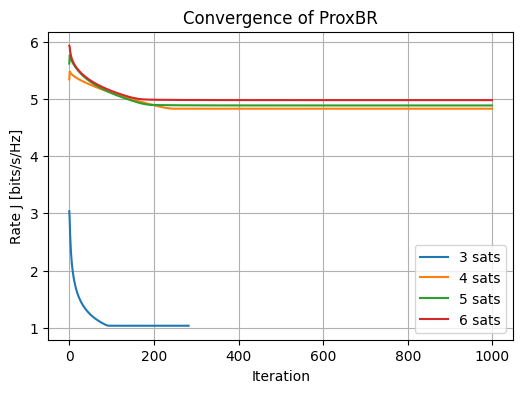

In [17]:

# # -------------------------
# # Plot for convergence
# # -------------------------
for m in methods:
    plt.figure(figsize=(6,4))
    for k in sat_counts:
        hist = results[m][k]
        plt.plot(hist['J'], label=f"{k} sats")
    plt.xlabel("Iteration")
    plt.ylabel("Rate J [bits/s/Hz]")
    plt.title(f"Convergence of {m}")
    plt.legend()
    plt.grid(True)
    plt.show()


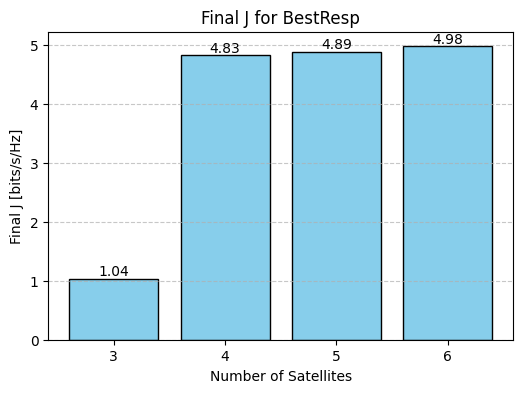

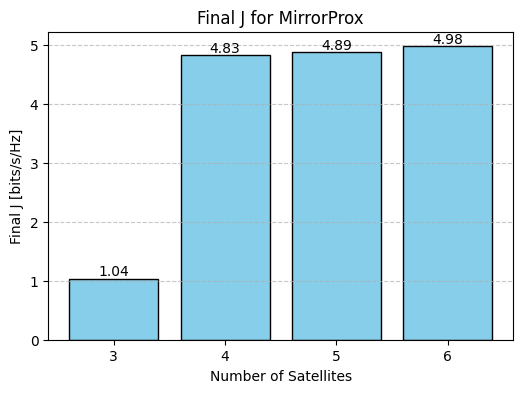

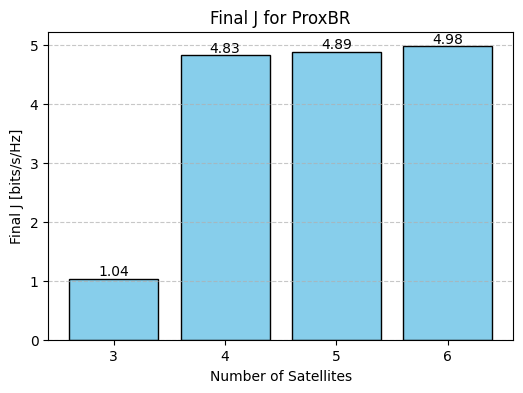

In [18]:
import matplotlib.pyplot as plt
import numpy as np

sat_counts = [3, 4, 5, 6]
methods = ["BestResp", "MirrorProx", "ProxBR"]

for m in methods:
    final_J = [results[m][k]['J'][-1] for k in sat_counts]
    plt.figure(figsize=(6,4))
    plt.bar([str(k) for k in sat_counts], final_J, color="skyblue", edgecolor="k")
    plt.xlabel("Number of Satellites")
    plt.ylabel("Final J [bits/s/Hz]")
    plt.title(f"Final J for {m}")
    for i, v in enumerate(final_J):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
